<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/%E7%8E%89%E5%B1%B1%E9%8A%80%E8%A1%8C%E6%AF%94%E8%B3%BD_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')
import seaborn as sns
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
中文map = {'bacno':'歸戶帳號','txkey':'交易序號','locdt':'授權日期','loctm':'授權時間','cano':'交易卡號',
         'contp':'交易類別','etymd':'交易型態','mchno':'特店代號','acqic':'收單行代碼','mcc':'MCC_CODE',
         'conam':'交易金額-台幣(經過轉換)','ecfg':'網路交易註記','insfg':'分期交易註記','iterm':'分期期數',
         'stocn':'消費地國別','scity':'消費城市','stscd':'狀態碼','ovrlt':'超額註記碼','flbmk':'Fallback註記',
         'hcefg':'支付型態','csmcu':'消費地幣別','flg_3dsmk':'3DS交易註記','fraud_ind':'盜刷註記'}

In [0]:
num_Fold = 4
random_seed = 42

# train

In [4]:
import pandas as pd
train = pd.read_csv("/content/drive/My Drive/玉山人工智慧比賽數據/train_特徵工程完.csv",index_col=0)
print(train.shape)
train.head()

(1521787, 100)


,stscd,ecfg,stocn,acqic,etymd,loctm,scity,hcefg,contp,conam,insfg,ovrlt,flg_3dsmk,iterm,csmcu,mchno,cano,mcc,flbmk,bacno,cano_stscd_2_norm_count,bacno_stscd_2_norm_count,cano_stscd_nunique,bacno_stscd_nunique,cano_ecfg_0_norm_count,cano_stscd_2_count,bacno_ecfg_1_norm_count,bacno_stscd_2_count,cano_stocn_nunique,bacno_stocn_nunique,bacno_csmcu_nunique,cano_csmcu_nunique,cano_etymd_nunique,bacno_ecfg_nunique,bacno_scity_nunique,cano_ecfg_nunique,cano_ecfg_0_count,cano_mchno_nunique,cano_stscd_0_count,cano_insfg_nunique,...,bacno_ovrlt_nunique,locdt,cano_ecfg_1_count,bacno_iterm_nunique,bacno_insfg_0_norm_count,bacno_mcc_nunique,bacno_insfg_nunique,bacno_iterm_1_norm_count,cano_ovrlt_nunique,cano_iterm_2_norm_count,cano_iterm_4_count,cano_insfg_1_count,bacno_iterm_1_count,cano_stscd_1_norm_count,cano_contp_4_count,bacno_contp_nunique,bacno_etymd_nunique,bacno_stscd_1_norm_count,cano_ovrlt_1_count,bacno_flg_3dsmk_nunique,cano_iterm_4_norm_count,bacno_iterm_2_norm_count,bacno_contp_6_count,bacno_ovrlt_1_count,bacno_stscd_1_count,cano_contp_4_norm_count,cano_iterm_8_count,bacno_contp_4_norm_count,cano_iterm_2_count,bacno_contp_4_count,cano_iterm_7_count,bacno_iterm_4_norm_count,bacno_iterm_4_count,bacno_iterm_8_count,cano_stscd_1_count,cano_iterm_3_count,cano_iterm_6_count,cano_contp_3_norm_count,txkey,fraud_ind
0,0,0,102,6862,0,61954,0,5,5,16158,0,0,0,0,0,59034,37846,457,0,112785,0.0,0.0,1,1,0.712500,0,0.287500,0,5,5,3,3,5,2,13,2,57.0,33,80.0,1,...,1,33,23.0,1,1.000000,21,1,0.000000,1,0.0,0,0.0,0,0.0,0,3,5,0.0,0,1,0.0,0.0,1,0,0,0.000000,0,0.000000,0.0,0,0,0.0,0,0,0,0,0,0.0,516056,0
1,0,0,102,0,2,38216,5795,0,5,13693,0,0,0,0,0,0,45476,451,0,133951,0.0,0.0,1,1,0.913043,0,0.086957,0,1,1,2,2,4,2,4,2,21.0,11,23.0,2,...,1,9,2.0,2,0.956522,8,2,0.043478,1,0.0,0,1.0,1,0.0,0,1,4,0.0,0,2,0.0,0.0,0,0,0,0.000000,0,0.000000,0.0,0,0,0.0,0,0,0,0,0,0.0,4376,0
2,0,0,102,6862,0,54640,0,5,5,16158,0,0,0,0,0,59034,187354,457,0,15350,0.0,0.0,1,1,1.000000,0,0.000000,0,1,1,2,2,4,1,4,1,18.0,12,18.0,1,...,1,6,0.0,1,1.000000,7,1,0.000000,1,0.0,0,0.0,0,0.0,0,1,4,0.0,0,1,0.0,0.0,0,0,0,0.000000,0,0.000000,0.0,0,0,0.0,0,0,0,0,0,0.0,483434,0
3,0,0,102,6697,5,62128,3267,5,5,40413,0,0,0,0,62,50185,29812,247,0,156492,0.0,0.0,1,1,0.964912,0,0.027027,0,1,1,1,1,4,2,9,2,55.0,25,57.0,2,...,1,5,2.0,2,0.986486,14,2,0.013514,1,0.0,0,1.0,1,0.0,0,2,4,0.0,0,2,0.0,0.0,0,0,0,0.000000,0,0.000000,0.0,0,0,0.0,0,0,0,0,0,0.0,1407164,0
4,0,0,102,5959,4,65231,5795,5,5,25962,0,0,0,0,62,93290,80881,263,0,105534,0.0,0.0,1,1,0.761905,0,0.192308,0,1,1,2,2,5,2,8,2,48.0,28,63.0,1,...,1,6,15.0,1,1.000000,17,1,0.000000,1,0.0,0,0.0,0,0.0,3,3,5,0.0,0,2,0.0,0.0,0,0,0,0.047619,0,0.038462,0.0,3,0,0.0,0,0,0,0,0,0.0,1051004,0


# test

In [5]:
test = pd.read_csv("/content/drive/My Drive/玉山人工智慧比賽數據/test_特徵工程完.csv",index_col=0)
test_txkey = test["txkey"]
print(test.shape)
test.head()

(421665, 99)


,stscd,ecfg,stocn,acqic,etymd,loctm,scity,hcefg,contp,conam,insfg,ovrlt,flg_3dsmk,iterm,csmcu,mchno,cano,mcc,flbmk,bacno,cano_stscd_2_norm_count,bacno_stscd_2_norm_count,cano_stscd_nunique,bacno_stscd_nunique,cano_ecfg_0_norm_count,cano_stscd_2_count,bacno_ecfg_1_norm_count,bacno_stscd_2_count,cano_stocn_nunique,bacno_stocn_nunique,bacno_csmcu_nunique,cano_csmcu_nunique,cano_etymd_nunique,bacno_ecfg_nunique,bacno_scity_nunique,cano_ecfg_nunique,cano_ecfg_0_count,cano_mchno_nunique,cano_stscd_0_count,cano_insfg_nunique,...,cano_iterm_1_count,bacno_ovrlt_nunique,locdt,cano_ecfg_1_count,bacno_iterm_nunique,bacno_insfg_0_norm_count,bacno_mcc_nunique,bacno_insfg_nunique,bacno_iterm_1_norm_count,cano_ovrlt_nunique,cano_iterm_2_norm_count,cano_iterm_4_count,cano_insfg_1_count,bacno_iterm_1_count,cano_stscd_1_norm_count,cano_contp_4_count,bacno_contp_nunique,bacno_etymd_nunique,bacno_stscd_1_norm_count,cano_ovrlt_1_count,bacno_flg_3dsmk_nunique,cano_iterm_4_norm_count,bacno_iterm_2_norm_count,bacno_contp_6_count,bacno_ovrlt_1_count,bacno_stscd_1_count,cano_contp_4_norm_count,cano_iterm_8_count,bacno_contp_4_norm_count,cano_iterm_2_count,bacno_contp_4_count,cano_iterm_7_count,bacno_iterm_4_norm_count,bacno_iterm_4_count,bacno_iterm_8_count,cano_stscd_1_count,cano_iterm_3_count,cano_iterm_6_count,cano_contp_3_norm_count,txkey
1521787,0,0,102,6862,0,77950,0,5,5,16158,0,0,0,0,0,59060,116168,457,0,162489,0.181818,0.181818,2,2,1.0,2,0.0,2,1,1,1,1,1,1,1,1,11.0,1,9.0,1,...,0,1,102,0.0,1,1.0,1,1,0.0,1,0.0,0,0.0,0,0.0,0,1,1,0.0,0,1,0.0,0.0,0,0,0,0.0,0,0.0,0.0,0,0,0.0,0,0,0,0,0,0.0,592489
1521788,0,0,102,6862,0,79549,0,5,5,16158,0,0,0,0,0,59060,116168,457,0,162489,0.181818,0.181818,2,2,1.0,2,0.0,2,1,1,1,1,1,1,1,1,11.0,1,9.0,1,...,0,1,102,0.0,1,1.0,1,1,0.0,1,0.0,0,0.0,0,0.0,0,1,1,0.0,0,1,0.0,0.0,0,0,0,0.0,0,0.0,0.0,0,0,0.0,0,0,0,0,0,0.0,592452
1521789,0,0,102,6862,0,60355,0,5,5,16158,0,0,0,0,0,59060,116168,457,0,162489,0.181818,0.181818,2,2,1.0,2,0.0,2,1,1,1,1,1,1,1,1,11.0,1,9.0,1,...,0,1,100,0.0,1,1.0,1,1,0.0,1,0.0,0,0.0,0,0.0,0,1,1,0.0,0,1,0.0,0.0,0,0,0,0.0,0,0.0,0.0,0,0,0.0,0,0,0,0,0,0.0,590212
1521790,0,0,102,6862,0,60296,0,5,5,16158,0,0,0,0,0,59060,116168,457,0,162489,0.181818,0.181818,2,2,1.0,2,0.0,2,1,1,1,1,1,1,1,1,11.0,1,9.0,1,...,0,1,100,0.0,1,1.0,1,1,0.0,1,0.0,0,0.0,0,0.0,0,1,1,0.0,0,1,0.0,0.0,0,0,0,0.0,0,0.0,0.0,0,0,0.0,0,0,0,0,0,0.0,590209
1521791,0,0,102,6862,0,77933,0,5,5,16158,0,0,0,0,0,59060,116168,457,0,162489,0.181818,0.181818,2,2,1.0,2,0.0,2,1,1,1,1,1,1,1,1,11.0,1,9.0,1,...,0,1,102,0.0,1,1.0,1,1,0.0,1,0.0,0,0.0,0,0.0,0,1,1,0.0,0,1,0.0,0.0,0,0,0,0.0,0,0.0,0.0,0,0,0.0,0,0,0,0,0,0.0,592488


# 定義 features & cat_features & target

In [6]:
# all features
features = train.drop(['fraud_ind', # just target
                       'txkey', # just like index
                       'locdt',# just date
                       ],axis=1).columns.tolist()

# cat_features
cat_features = sorted(list(set(features)&set(中文map.keys())))

y_name = 'fraud_ind'

print(len(features),features)
print(len(cat_features),cat_features)
print(len([y_name]),[y_name])

97 ['stscd', 'ecfg', 'stocn', 'acqic', 'etymd', 'loctm', 'scity', 'hcefg', 'contp', 'conam', 'insfg', 'ovrlt', 'flg_3dsmk', 'iterm', 'csmcu', 'mchno', 'cano', 'mcc', 'flbmk', 'bacno', 'cano_stscd_2_norm_count', 'bacno_stscd_2_norm_count', 'cano_stscd_nunique', 'bacno_stscd_nunique', 'cano_ecfg_0_norm_count', 'cano_stscd_2_count', 'bacno_ecfg_1_norm_count', 'bacno_stscd_2_count', 'cano_stocn_nunique', 'bacno_stocn_nunique', 'bacno_csmcu_nunique', 'cano_csmcu_nunique', 'cano_etymd_nunique', 'bacno_ecfg_nunique', 'bacno_scity_nunique', 'cano_ecfg_nunique', 'cano_ecfg_0_count', 'cano_mchno_nunique', 'cano_stscd_0_count', 'cano_insfg_nunique', 'cano_iterm_nunique', 'cano_scity_nunique', 'cano_contp_nunique', 'cano_contp_2_norm_count', 'bacno_ecfg_0_count', 'cano_hcefg_nunique', 'cano_contp_2_count', 'cano_mcc_nunique', 'cano_contp_5_norm_count', 'bacno_contp_2_norm_count', 'bacno_stscd_0_count', 'cano_ovrlt_1_norm_count', 'cano_flg_3dsmk_nunique', 'bacno_contp_5_norm_count', 'bacno_contp_2_

# both / test

In [7]:
f = {}
for col in cat_features:
  both_value = set(train[col].unique())&set(test[col].unique())
  f[col] = len(both_value)/len(test[col].unique())
res = pd.DataFrame(f,index=['both/test']).T.sort_values(by='both/test',ascending=False)
res['中文'] = res.index.map(中文map)
res

,both/test,中文
stscd,1.000000,狀態碼
ovrlt,1.000000,超額註記碼
contp,1.000000,交易類別
ecfg,1.000000,網路交易註記
etymd,1.000000,交易型態
flbmk,1.000000,Fallback註記
flg_3dsmk,1.000000,3DS交易註記
insfg,1.000000,分期交易註記
iterm,1.000000,分期期數
loctm,0.990267,授權時間


# drop rare features

In [8]:
print(len(features))
try:
  features.remove('bacno')
  features.remove('cano')
except:
  pass
print(len(features))

97
95


In [9]:
print(len(cat_features))
try:
  cat_features.remove('bacno')
  cat_features.remove('cano')
except:
  pass
print(len(cat_features))

20
18


# 切分 train 跟 val

In [0]:
from sklearn.model_selection import KFold
# random_seed影響Fold生成方式,進而影響train和val,進而影響train出來的model 
kf = KFold(n_splits = 5 ,random_state=random_seed)
Folds = {}
for i,train_val_index in enumerate(kf.split(train.index)):
  Folds[i] = train_val_index

In [0]:
#num_Fold影響train,進而影響model
train_index ,val_index = Folds[num_Fold]

In [0]:
val = train.loc[val_index,features+[y_name]]
train = train.loc[train_index,features+[y_name]]

# val 再切分 val_1,val_2

In [13]:
from sklearn.model_selection import train_test_split
#random_seed影響切分方式,進而影響val_1,val_2,進而影響後續評分
val_1 ,val_2 = train_test_split(val[features+[y_name]] ,test_size=0.5 ,random_state=random_seed)
print(train.shape)
print(val_1.shape)
print(val_2.shape)

(1217430, 96)
(152178, 96)
(152179, 96)


# 計算class weight

考慮到樣本class不平衡問題

In [14]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_org = train[y_name].append(val[y_name])

class_weight_dict = dict(zip([0,1],
                             compute_class_weight(class_weight ='balanced',
                                                  classes = np.unique(y_org),
                                                  y = y_org)))
class_weight_dict = list(class_weight_dict.values())
class_weight_dict

[0.5067785287645394, 37.381159420289855]

# scaler 數值特徵

In [15]:
#產生數值特徵列表
num_feat = list(set(features)^set(cat_features))
num_feat

['cano_ovrlt_nunique',
 'cano_stscd_1_count',
 'cano_insfg_1_norm_count',
 'bacno_stscd_1_count',
 'bacno_contp_4_norm_count',
 'bacno_contp_4_count',
 'cano_etymd_nunique',
 'bacno_stscd_0_count',
 'bacno_insfg_0_norm_count',
 'cano_flbmk_nunique',
 'cano_iterm_4_norm_count',
 'cano_iterm_2_norm_count',
 'cano_ovrlt_1_norm_count',
 'cano_iterm_2_count',
 'cano_iterm_4_count',
 'cano_ecfg_0_norm_count',
 'bacno_ovrlt_nunique',
 'cano_iterm_1_count',
 'cano_mchno_nunique',
 'bacno_iterm_2_norm_count',
 'cano_iterm_8_count',
 'cano_ecfg_nunique',
 'cano_iterm_1_norm_count',
 'cano_iterm_6_count',
 'bacno_iterm_1_count',
 'cano_stscd_nunique',
 'bacno_csmcu_nunique',
 'bacno_ovrlt_1_count',
 'cano_contp_2_count',
 'bacno_stscd_nunique',
 'cano_insfg_nunique',
 'bacno_contp_5_norm_count',
 'cano_flg_3dsmk_nunique',
 'cano_contp_2_norm_count',
 'cano_ecfg_0_count',
 'cano_scity_nunique',
 'bacno_ecfg_nunique',
 'bacno_contp_2_count',
 'cano_iterm_nunique',
 'cano_contp_nunique',
 'bacno_ety

In [0]:
from sklearn.preprocessing import StandardScaler
# fit on "full" data's num_feat
scaler =  StandardScaler().fit(train[num_feat].append(val[num_feat]).append(test[num_feat]))
# transform "each" data's num_feat
train[num_feat] = scaler.transform(train[num_feat])
val_1[num_feat] = scaler.transform(val_1[num_feat])
val_2[num_feat] = scaler.transform(val_2[num_feat])
test[num_feat] = scaler.transform(test[num_feat])

In [17]:
import gc
gc.collect()

0

# modelling

準備類別特徵

In [18]:
train[features].columns

Index(['stscd', 'ecfg', 'stocn', 'acqic', 'etymd', 'loctm', 'scity', 'hcefg',
       'contp', 'conam', 'insfg', 'ovrlt', 'flg_3dsmk', 'iterm', 'csmcu',
       'mchno', 'mcc', 'flbmk', 'cano_stscd_2_norm_count',
       'bacno_stscd_2_norm_count', 'cano_stscd_nunique', 'bacno_stscd_nunique',
       'cano_ecfg_0_norm_count', 'cano_stscd_2_count',
       'bacno_ecfg_1_norm_count', 'bacno_stscd_2_count', 'cano_stocn_nunique',
       'bacno_stocn_nunique', 'bacno_csmcu_nunique', 'cano_csmcu_nunique',
       'cano_etymd_nunique', 'bacno_ecfg_nunique', 'bacno_scity_nunique',
       'cano_ecfg_nunique', 'cano_ecfg_0_count', 'cano_mchno_nunique',
       'cano_stscd_0_count', 'cano_insfg_nunique', 'cano_iterm_nunique',
       'cano_scity_nunique', 'cano_contp_nunique', 'cano_contp_2_norm_count',
       'bacno_ecfg_0_count', 'cano_hcefg_nunique', 'cano_contp_2_count',
       'cano_mcc_nunique', 'cano_contp_5_norm_count',
       'bacno_contp_2_norm_count', 'bacno_stscd_0_count',
       'cano_ovrlt_

In [19]:
#類別特徵索引
cate_features_index = np.where(train[features].dtypes != float)[0]
cate_features_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

# 定義模型

In [0]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    class_weights = [1.0,2.5],#因為樣本不平衡,盜刷樣本比較少
    #learning_rate = 0.1/2, #學習率,不設定catboost會自己set
    iterations = 250,# 跑幾次迭代,250次,省時間
    loss_function = 'Logloss',#因為是二分類問題
    eval_metric = 'F1',#主辦單位指定評估指標
    use_best_model = True,#使用最好model
    random_seed = random_seed,#設定隨機種子
    task_type="GPU",#用GPU加速
    )

# 訓練

In [21]:
model.fit(train[features],train[y_name], #訓練資料
          eval_set = (val_1[features],val_1[y_name]), #val_1當驗證資料
          cat_features = cate_features_index, #指定類別特徵索引
          )

Learning rate set to 0.297786
0:	learn: 0.6637846	test: 0.6799145	best: 0.6799145 (0)	total: 347ms	remaining: 1m 26s
1:	learn: 0.6746568	test: 0.6933225	best: 0.6933225 (1)	total: 663ms	remaining: 1m 22s
2:	learn: 0.6804159	test: 0.6954159	best: 0.6954159 (2)	total: 896ms	remaining: 1m 13s
3:	learn: 0.6889582	test: 0.7049190	best: 0.7049190 (3)	total: 1.17s	remaining: 1m 11s
4:	learn: 0.6926542	test: 0.7054037	best: 0.7054037 (4)	total: 1.45s	remaining: 1m 11s
5:	learn: 0.6941370	test: 0.7081926	best: 0.7081926 (5)	total: 1.66s	remaining: 1m 7s
6:	learn: 0.7055117	test: 0.7147758	best: 0.7147758 (6)	total: 2s	remaining: 1m 9s
7:	learn: 0.7143156	test: 0.7274983	best: 0.7274983 (7)	total: 2.32s	remaining: 1m 10s
8:	learn: 0.7168409	test: 0.7312409	best: 0.7312409 (8)	total: 2.67s	remaining: 1m 11s
9:	learn: 0.7207514	test: 0.7311586	best: 0.7312409 (8)	total: 2.94s	remaining: 1m 10s
10:	learn: 0.7254852	test: 0.7402048	best: 0.7402048 (10)	total: 3.25s	remaining: 1m 10s
11:	learn: 0.728

# plot train history

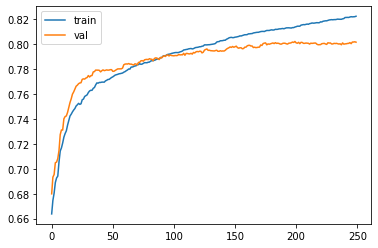

In [22]:
plt.plot(model.evals_result_['learn']['F1:use_weights=true'],label='train')
plt.plot(model.evals_result_['validation']['F1:use_weights=true'],label='val')
plt.legend()
plt.show()

# plot features importance

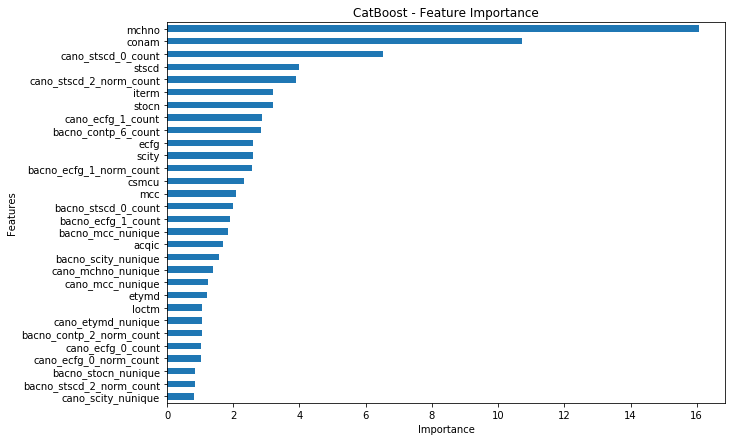

In [23]:
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': features})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

# val_2's F1 report

第二份驗證集

In [24]:
from sklearn.metrics import classification_report 

#轉01
val_2_pred_01 = pd.Series(model.predict(val_2[features])).apply(round)
#F1 score
print(classification_report(val_2[y_name],val_2_pred_01,target_names=['0','1']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    150230
           1       0.74      0.71      0.72      1949

    accuracy                           0.99    152179
   macro avg       0.87      0.85      0.86    152179
weighted avg       0.99      0.99      0.99    152179



# 產生submission

In [25]:
submission = pd.DataFrame({"txkey":test_txkey,
                           "fraud_ind":model.predict(test[features])})

# to [0,1] 
submission["fraud_ind"] = submission["fraud_ind"].apply(round)

# value_counts
print(submission["fraud_ind"].value_counts())
submission.head()

0    414691
1      6974
Name: fraud_ind, dtype: int64


,txkey,fraud_ind
1521787,592489,0
1521788,592452,0
1521789,590212,0
1521790,590209,0
1521791,592488,0


# 這裡有個想法如果test上盜刷的比例 跟train上面盜刷的比例 愈相近愈好

In [26]:
train_p = round((train['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(train['fraud_ind']))*100 ,5) #總數

val_1_p = round((val_1['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(val_1['fraud_ind']))*100 ,5) #總數

val_2_p = round((val_2['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(val_2['fraud_ind']))*100 ,5) #總數

test_p = round((submission['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(submission['fraud_ind']))*100 ,5) #總數
pd.DataFrame({'train_p':train_p,
              'val_1_p':val_1_p,
              'val_2_p':val_2_p,
              'test_p':test_p},
               index=['盜刷比例%'])

,train_p,val_1_p,val_2_p,test_p
盜刷比例%,1.34759,1.31425,1.28073,1.65392


# 轉換成機率,好做後續voting

In [27]:
submission['fraud_ind'] = model.predict_proba(test[features])[:,1]
submission.sample(10)

,txkey,fraud_ind
1911422,1534037,0.001128
1591857,789366,0.072382
1554455,794779,0.003851
1576909,802042,0.003310
1809426,327368,0.000457
1666775,1683083,0.000586
1881416,1683841,0.000811
1830957,800751,0.010354
1614189,445193,0.000924
1705371,1463075,0.000578


# 保存預測結果

In [28]:
print(num_Fold,random_seed)

4 42


In [0]:
path='/content/drive/My Drive/玉山人工智慧比賽數據/catboost_result/1108/catboost_Fold{}_random{}.csv'.format(num_Fold,random_seed)
submission.to_csv(path)